In [1]:
%load_ext lab_black

In [434]:
# Seed value (can actually be different for each attribution step)
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ["PYTHONHASHSEED"] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
import tensorflow as tf
from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import os
import itertools
from multiprocessing.pool import ThreadPool

import numpy as np
import ee
import pandas as pd
import tqdm
import folium
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures,
    StandardScaler,
)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Dense,
    Activation,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras import regularizers, initializers
from keras import backend as K

In [ ]:
ee.Authenticate()

In [3]:
ee.Initialize()

In [3]:
path = os.path.join("/home", "augusto", "Github", "DesafioAgTech2020")
os.chdir(path)

In [110]:
etiquetas = pd.read_csv(path + "/dataset/Etiquetas.csv")
train = pd.read_csv(path + "/dataset/data_train.csv")
test = pd.read_csv(path + "/dataset/data_test.csv")

In [111]:
train = pd.merge(train, etiquetas, on="Cultivo")
train["Tipo"] = train["Tipo"].apply(
    lambda x: x.replace(" ", "_").replace(",", "").lower()
)

In [737]:
train_augmented = pd.read_csv("train_v4_augmented.csv")
valid_augmented = pd.read_csv("valid_v4_augmented.csv")

In [742]:
remove_labels = ["girasol"]
train_augmented = train_augmented.query(f"etiqueta not in {remove_labels}")
valid_augmented = valid_augmented.query(f"etiqueta not in {remove_labels}")

train_augmented.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)
valid_augmented.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)

X_train_augmented, y_train_augmented = process_features(
    train_augmented, label="cultivo"
)

X_valid_augmented, y_valid_augmented = process_features(
    valid_augmented, label="cultivo"
)

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(X_train_augmented, title="Revision Features", minimal=True)
report.to_notebook_iframe();

Always standardize AFTER generating PolynomialFeatures. 1.) Loss of signal. When you create feature interactions, you're generating values that are multiples and squares of themselves.

In [743]:
sc_X = StandardScaler()
X_encoded_train = sc_X.fit_transform(X_train_augmented)
X_encoded_valid = sc_X.transform(X_valid_augmented)

oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(
    X_encoded_train, y_train_augmented
)

# encode class values as integers
encoder = LabelEncoder()
encoded_Y_train = encoder.fit_transform(y_train_augmented)
encoded_Y_train_balanced = encoder.fit_transform(y_train_balanced)
encoded_Y_valid = encoder.transform(y_valid_augmented)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = keras.utils.to_categorical(encoded_Y_train)
dummy_y_train_balanced = keras.utils.to_categorical(encoded_Y_train_balanced)
dummy_y_valid = keras.utils.to_categorical(encoded_Y_valid)

In [744]:
n_classes = dummy_y_train.shape[1]

In [677]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [746]:
model = Sequential()
model.add(
    Dense(
        256,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-5),
        bias_initializer="zeros",
    )
)
model.add(Dropout(0.5))
model.add(
    Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-5),
        bias_initializer="zeros",
    )
)
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation="softmax"))
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy", recall_m, precision_m, f1_m],
)

model.fit(
    X_train_balanced,
    dummy_y_train_balanced,
    epochs=1,
    validation_data=(X_encoded_valid, dummy_y_valid),
)

6988/6988 [==============================] - 14s 2ms/step - loss: 0.5056 - accuracy: 0.8281 - recall_m: 0.7611 - precision_m: 0.8946 - f1_m: 0.8165 - val_loss: 1.3546 - val_accuracy: 0.6718 - val_recall_m: 0.6327 - val_precision_m: 0.6776 - val_f1_m: 0.6484


In [747]:
model.fit(
    X_train_balanced,
    dummy_y_train_balanced,
    epochs=1,
    validation_data=(X_encoded_valid, dummy_y_valid),
)

6988/6988 [==============================] - 14s 2ms/step - loss: 0.2762 - accuracy: 0.9068 - recall_m: 0.8859 - precision_m: 0.9276 - f1_m: 0.9058 - val_loss: 1.6652 - val_accuracy: 0.6906 - val_recall_m: 0.6719 - val_precision_m: 0.6954 - val_f1_m: 0.6807


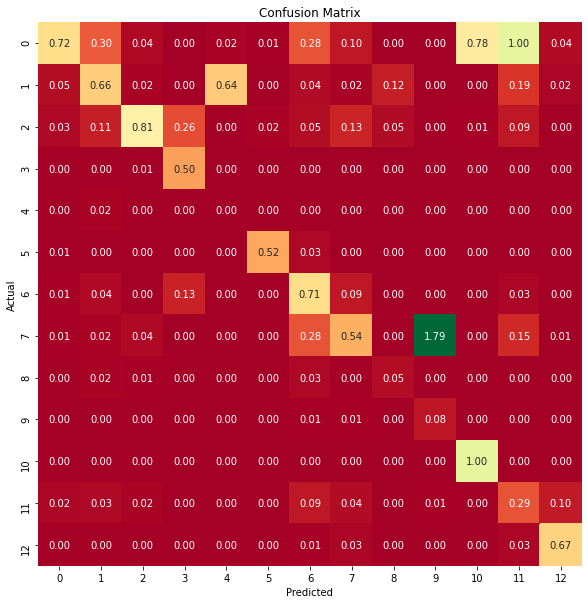

Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.72      0.78     18500
           2       0.55      0.66      0.60      5200
           3       0.86      0.81      0.84     11700
           4       0.56      0.50      0.53       200
           5       0.00      0.00      0.00       100
           8       0.94      0.52      0.67       400
           9       0.46      0.71      0.56      2800
          10       0.56      0.54      0.55      4400
          11       0.25      0.05      0.09       300
          15       0.04      0.08      0.06       100
          19       0.56      1.00      0.72       100
          23       0.16      0.29      0.20      1800
          24       0.79      0.67      0.72       600

    accuracy                           0.69     46200
   macro avg       0.51      0.50      0.49     46200
weighted avg       0.73      0.69      0.70     46200



In [748]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generamos las etiquetas predichas por nuestra red
y_pred = model.predict(X_encoded_valid)
test_pred = encoder.inverse_transform(np.argmax(y_pred, axis=1))
test_labels_ = y_valid_augmented

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(test_labels_, test_pred)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".2f",
    square=True,
    cbar=False,
    cmap=plt.cm.RdYlGn,
    ax=ax,
)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
ax.set_title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(test_labels_, test_pred))

SMOTE

In [749]:
full_df = train_augmented.append(valid_augmented, ignore_index=True)
full_x, full_y = process_features(full_df, label="cultivo")
sc_final = StandardScaler()
X_encoded_final = sc_final.fit_transform(full_x)

oversample = SMOTE()
X_final_balanced, y_final_balanced = oversample.fit_resample(X_encoded_final, full_y)

# encode class values as integers
encoder_final = LabelEncoder()
encoded_Y_final_balanced = encoder_final.fit_transform(y_final_balanced)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_final_balanced = keras.utils.to_categorical(encoded_Y_final_balanced)

In [752]:
model = Sequential()
model.add(
    Dense(
        256,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-5),
        bias_initializer="zeros",
    )
)
model.add(Dropout(0.5))
model.add(
    Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-5),
        bias_initializer="zeros",
    )
)
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation="softmax"))
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy", recall_m, precision_m, f1_m],
)

model.fit(X_final_balanced, dummy_y_final_balanced, epochs=1, shuffle=True)

14504/14504 [==============================] - 26s 2ms/step - loss: 0.5124 - accuracy: 0.8266 - recall_m: 0.7624 - precision_m: 0.8893 - f1_m: 0.8163


In [753]:
model.fit(
    X_final_balanced, dummy_y_final_balanced, epochs=1,
)

14504/14504 [==============================] - 26s 2ms/step - loss: 0.3354 - accuracy: 0.8863 - recall_m: 0.8602 - precision_m: 0.9121 - f1_m: 0.8849


In [ ]:
model.save("modelo_ganador.h5")

## **Final pipeline**

In [113]:
def get_bands_info(row):
    latitud = row["Latitud"]
    longitud = row["Longitud"]
    bands = get_coord_bands(
        long=longitud,
        lat=latitud,
        start_year=row["start_year"],
        end_year=row["end_year"],
    )
    data = {
        "latitud": latitud,
        "longitud": longitud,
        "elevacion": row["Elevacion"],
        **bands,
    }
    return data

In [120]:
thread_pool = ThreadPool(8)
test_bands = thread_pool.map(get_bands_info, test.to_dict(orient="records"))
test_final = pd.DataFrame(test_bands)
test_final.to_csv("test_data_v4.csv", index=False)

In [754]:
test_final = pd.read_csv("test_data_v4.csv")

In [755]:
X_final, _ = process_features(test_final)
X_final.drop(["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True)

In [756]:
X_encoded_test = sc_final.transform(X_final)

In [757]:
preds = model.predict(X_encoded_test)

(array([ 15.,  22.,  34.,  26.,  27.,  37.,  44.,  58., 100., 192.]),
 array([0.3393698 , 0.40543282, 0.47149584, 0.53755885, 0.6036219 ,
        0.6696849 , 0.73574793, 0.8018109 , 0.86787397, 0.93393695,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

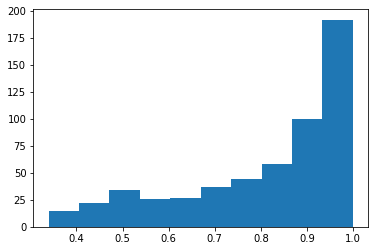

In [402]:
pd.DataFrame(np.argmax(preds, axis=1))

preds.max(axis=1)

np.argwhere(preds > 0.01)

(preds.max(axis=1) < 0.4).mean()

plt.hist(preds.max(axis=1))

In [540]:
argmax = test.copy()
argmax["argmax"] = pd.DataFrame(
    encoder_final.inverse_transform(np.argmax(preds, axis=1))
)
argmax["prob"] = np.max(preds, axis=1)

In [541]:
argmax["corrected_pred"] = np.where(argmax["prob"] < 0.5, 23, argmax["argmax"])

In [543]:
argmax[["GlobalId", "corrected_pred"]].to_csv(
    "preds_sadosky_nn_filtered_2.csv", header=None, index=False
)

In [759]:
qq = test.copy()
qq["preds"] = encoder_final.inverse_transform(np.argmax(preds, axis=1))